# Unsupervised Spectral Unmixing with Autoencoders

By Joshua C. Agar, Shuyu Qin

* There are many times where you want to extract imporant features from high-dimensional data
* In essence, the goal is to compress data to some lower latent space where you can extract information

![](https://prateekvjoshi.files.wordpress.com/2014/06/3-swissroll-unfolded.png)

# Autoencoder
* **Encoder** - Neural network that deconstructs the data into the most important statistical components
* **Embedding Layer(s)** - One or many layers were information is extracted
* **Decoder** - Neural network that translates the latent space to original dimensionality. 

## Mathamatical Objective
* Minimize the reconstruction loss based on some metric. 
  * Mean squared errror

  Good at avoiding influence of anomolies
  * Mean absolute error

  Good at capturing details within spectra

## Optimizers
* Standard optimizers like ADAM tend to be suffiecent
* Can use more complex optimizers 2nd order, adhessian to optimize small models. 

## Practical Objective
* Create an autoencoder that has performant reconstruction
* Create a low-dimensional and interpretable latent space
  * Reduce the dimensionality
  * Impose non-negativity contraints
  * Impose regularization
  * Impose sparsity
  * Impose constraints on the shape of the latent distribution
  * Impose soft-constraints that favor disentanglement
* Create a latent trajectory that is suitable for generation 

In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
#from tensorflow.keras.models import Model
#from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import tensorflow as tf
import torch
from tqdm import tqdm
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# Loads dog image
image = io.imread('/content/drive/MyDrive/Tutorials/MyTutorials/CNMS Deep Learning/nala.jpg')

# Crops dog image
image = image[200:1900:20, 100:1500:20]/255

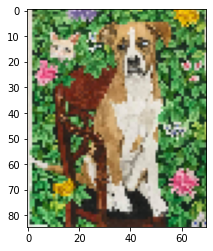

In [3]:
plt.imshow(image)

Lets look at what the spectra looks like

In [4]:
tanh = nn.Tanh()
selu = nn.SELU()
sigmoid = nn.Sigmoid()

In [5]:
def non_linear_fn(t, x, y, z):
  # returns a function from variables
  return tanh(torch.tensor(20*(t - 2*(x-.5)))) + selu(torch.tensor((t-2*(y-0.5)))) + sigmoid(torch.tensor(-20*(t-(z-0.5))))

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def layout_fig(graph, mod=None):

    """
    function

    :param graph: number of axes to make
    :type graph: int
    :param mod: sets the number of figures per row
    :type mod: int (, optional)
    :return: fig:
                handel to figure being created
             axes:
                numpy array of axes that are created
    :rtype: fig:
                matplotlib figure
            axes:
                numpy array
    """

    # Sets the layout of graphs in matplotlib in a pretty way based on the number of plots
    if mod is None:
        # Selects the number of columns to have in the graph
        if graph < 3:
            mod = 2
        elif graph < 5:
            mod = 3
        elif graph < 10:
            mod = 4
        elif graph < 17:
            mod = 5
        elif graph < 26:
            mod = 6
        elif graph < 37:
            mod = 7

    # builds the figure based on the number of graphs and selected number of columns
    fig, axes = plt.subplots(graph // mod + (graph % mod > 0), mod,
                             figsize=(3 * mod, 3 * (graph // mod + (graph % mod > 0))))

    # deletes extra unneeded axes
    axes = axes.reshape(-1)
    for i in range(axes.shape[0]):
        if i + 1 > graph:
            fig.delaxes(axes[i])

    return (fig, axes)


def embedding_maps(data, image, colorbar_shown=True,
                   c_lim=None, mod=None,
                   title=None):

    """

    :param data: data need to be showed in image format
    :type data: array
    :param image: the output shape of the image
    :type image: array
    :param colorbar_shown: whether to show the color bar on the left of image
    :type colorbar_shown: boolean
    :param c_lim: Sets the scales of colorbar
    :type c_lim: list
    :param mod: set the number of image for each line
    :type mod: int
    :param title: set the title of figure
    :type title: string
    :return: handel to figure being created
    :rtype: matplotlib figure
    """
    fig, ax = layout_fig(data.shape[1], mod)

    for i, ax in enumerate(ax):
        if i < data.shape[1]:
            im = ax.imshow(data[:, i].reshape(image.shape[0], image.shape[1]))
            ax.set_xticklabels('')
            ax.set_yticklabels('')

            # adds the colorbar
            if colorbar_shown == True:
                divider = make_axes_locatable(ax)
                cax = divider.append_axes('right', size='10%', pad=0.05)
                cbar = plt.colorbar(im, cax=cax, format='%.1e')

                # Sets the scales
                if c_lim is not None:
                    im.set_clim(c_lim)

    if title is not None:
        # Adds title to the figure
        fig.suptitle(title, fontsize=16,
                     y=1, horizontalalignment='center')

    fig.tight_layout()

In [7]:
def generate_data(values, function=non_linear_fn, length=25, range_=[-1, 1]):
    """
    Function to generate data from values

    :param values: values to function for generating spectra
    :type values: float
    :param function:  mathematical expression used to generate spectra
    :type function: function, optional
    :param length: spectral length
    :type length: int (optional)
    :param range_: x range for function
    :type range_:  list of float
    :return: generatered spectra
    :rtype: array of float
    """

    # build x vector
    x = np.linspace(range_[0], range_[1], length)

    data = np.zeros((values.shape[0], length))

    for i in range(values.shape[0]):
        data[i, :] = function(x, values[i, 0], values[i, 1], values[i, 2])

    return data

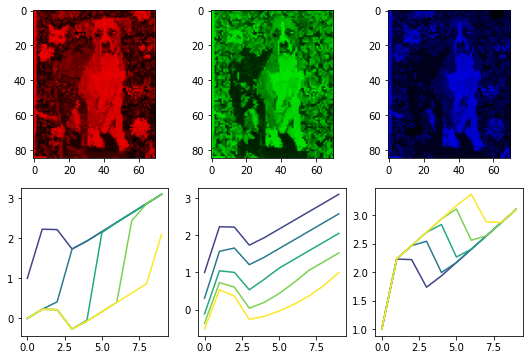

In [8]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis 

for i, ax in enumerate(ax):
  if i<3:
    img = np.zeros(image.shape)
    img[:,:,i] = image[:,:,i]
    ax.imshow(img)
  else:
    values = np.zeros((5,3))
    values[:,i-3] = np.linspace(0,1,5)
    y_data = generate_data(values, length=10)
    for j in range(y_data.shape[0]):
      color = cmap((j + 1) / y_data.shape[0])
      ax.plot(y_data[j], c=color)

In [9]:
dog_data = generate_data(image.reshape(-1,3),length=10)

X_train, X_test, _, _ = train_test_split(dog_data, dog_data, 
                                        test_size=0.2, random_state=42)

Let's Build a Simple Autoencoder

In [10]:
latent_dim =12

class Encoder(nn.Module):
    
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder,self).__init__()
        self.dense_1 = nn.Linear(10,self.latent_dim)

    def forward(self, x):
      x = self.dense_1(x)
      return x

class Decoder(nn.Module):
    
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder,self).__init__()
        self.dense_1 = nn.Linear(self.latent_dim,10)

    def forward(self, x):
      x = self.dense_1(x)
      return x

In [11]:
class Autoencoder(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # encode
        embedding = self.encoder(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize

        # decode
        predicted = self.decoder(embedding)
        
        return predicted

In [225]:
def loss_function(model,
                  encoder,
                  decoder,
                  train_iterator,
                  optimizer,
                  coef = 0, 
                  coef1 = 0,
                  ln_parm = 1, 
                  beta = None):

    weight_decay = coef
    weight_decay_1 = coef1

    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0
    #    for i, x in enumerate(train_iterator):
    for x in tqdm(train_iterator, leave=True, total=len(train_iterator)):

        
        reg_loss_2 = Regularization(model, weight_decay_1, p=2).to(device)
     

        x = x.to(device, dtype=torch.float)

        # update the gradients to zero
        optimizer.zero_grad()

        if beta is None: 
        
          embedding = encoder(x)
        
        else:
        
          # forward pass
          #        predicted_x = model(x)
          embedding,sd,mn = encoder(x)
        
        if weight_decay > 0:
            reg_loss_1 = weight_decay * torch.norm(embedding, ln_parm).to(device)
        else:
            reg_loss_1 = 0.0 

        predicted_x = decoder(embedding)

        # reconstruction loss
        loss = F.mse_loss(x, predicted_x, reduction='mean')

        
        loss = loss + reg_loss_2(model) + reg_loss_1
            
        if beta is not None:
            vae_loss = beta * 0.5 * torch.sum(torch.exp(sd) + (mn)**2 - 1.0 - sd).to(device)
            vae_loss/= (sd.shape[0]*sd.shape[1])
        else:
            vae_loss=0

        loss = loss + vae_loss
        
        # backward pass
        train_loss += loss.item()

        loss.backward()
        # update the weights
        optimizer.step()

    return train_loss

In [218]:
class Regularization(nn.Module):
    def __init__(self, model, weight_decay, p=2):
        '''
        :param model
        :param weight_decay: coeifficient of 
        :param p: p=1 is l1 regularization, p=2 is l2 regularizaiton
        '''
        super(Regularization, self).__init__()
        if weight_decay < 0:
            print("param weight_decay can not <0")
            exit(0)
        self.model = model
        self.weight_decay = weight_decay
        self.p = p
        self.weight_list = self.get_weight(model)

    def to(self, device):
        '''
        :param device: cude or cpu
        :return:
        '''
        self.device = device
        super().to(device)
        return self

    def forward(self, model):
        self.weight_list = self.get_weight(model)  
        reg_loss = self.regularization_loss(self.weight_list, self.weight_decay, p=self.p)
        return reg_loss

    def get_weight(self, model):
        '''
        :param model: model
        :return: list of layers needs to be regularized  
        '''
        weight_list = []
        for name, param in model.named_parameters():
            if 'dec' in name and 'weight' in name:
                weight = (name, param)
                weight_list.append(weight)
        return weight_list

    def regularization_loss(self, weight_list, weight_decay, p):
        '''
        :param weight_list: list of layers needs to be regularized  
        :param p: p=1 is l1 regularization, p=2 is l2 regularizaiton
        :param weight_decay: coeifficient
        :return: loss
        '''
        reg_loss = 0
        for name, w in weight_list:
            l2_reg = torch.norm(w, p=p)
            reg_loss = reg_loss + l2_reg

        reg_loss = weight_decay * reg_loss
        return reg_loss

    def weight_info(self, weight_list):
        '''
        :param weight_list:
        :return: list of layers' name needs to be regularized  
        '''
        print("---------------regularization weight---------------")
        for name, w in weight_list:
            print(name)

In [223]:
def Train(model,encoder,decoder,train_iterator,optimizer,
          epochs, coef=0,coef_1=0,ln_parm=1, beta=None):
    
    N_EPOCHS = epochs
    best_train_loss = float('inf')
    
    for epoch in range(N_EPOCHS):

        train = loss_function(model,encoder,decoder,train_iterator,
                              optimizer,coef,coef_1,ln_parm,beta)
        train_loss = train
        train_loss /= len(train_iterator)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}')
        print('.............................')

        if best_train_loss > train_loss:
            best_train_loss = train_loss
            patience_counter = 1
            checkpoint = {
                "net": model.state_dict(),
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                "encoder": encoder.state_dict(), 
                'decoder': decoder.state_dict()
            }
            if epoch >=0:
              torch.save(checkpoint, f'/test__Train Loss:{train_loss:.4f}-{epoch}.pkl') 


In [ ]:
latent_dim =12
 
 # input (batch,)
class Encoder(nn.Module):
    
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder,self).__init__()
        self.lstm = nn.LSTM(1,12,batch_first=True,bidirectional=True)
        self.embedding = nn.Linear(24,self.latent_dim)
        self.relu = nn.ReLU()


    def forward(self, x):
 #     x = x.transpose(1,2)
      
      x,(_,__) = self.lstm(x)
      x = x[:,-1,:]
      x = self.embedding(x)
      x = self.relu(x)
      return x

class Decoder(nn.Module):
    
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder,self).__init__()
        self.lstm = nn.LSTM(3,12,batch_first=True,bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
      x = x[:, :, None]
      x = x.transpose(1,2)
      x = x.repeat([1,10,1])
      x,(_,__) = self.lstm(x)
      x = x.transpose(1,2)
      x = self.tdd(x)
      x = x.transpose(1,2)
      return x

In [ ]:
device = 'cuda' 

encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
train_iterator = torch.utils.data.DataLoader(np.atleast_3d(X_train),batch_size = 256,shuffle = False)

In [ ]:
torch.manual_seed(0)
Train(model,encoder,decoder,train_iterator,optimizer,500)

In [ ]:
encoded_spectra = encoder(torch.tensor(np.atleast_3d(dog_data),dtype=torch.float32).to(device))
decoded_spectra = decoder(encoded_spectra)

torch.Size([5950, 10, 24])


In [ ]:
encoded_spectra = encoded_spectra.to('cpu')
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to('cpu')
decoded_spectra = decoded_spectra.detach().numpy()

In [ ]:
maps = encoded_spectra.reshape(image.shape[0], image.shape[1],-1)

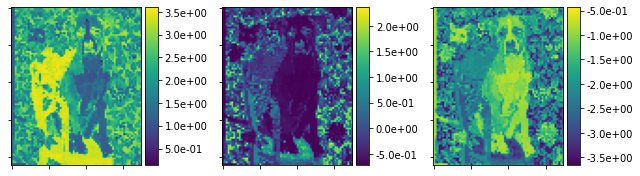

In [ ]:
embedding_maps(encoded_spectra, image)

torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])


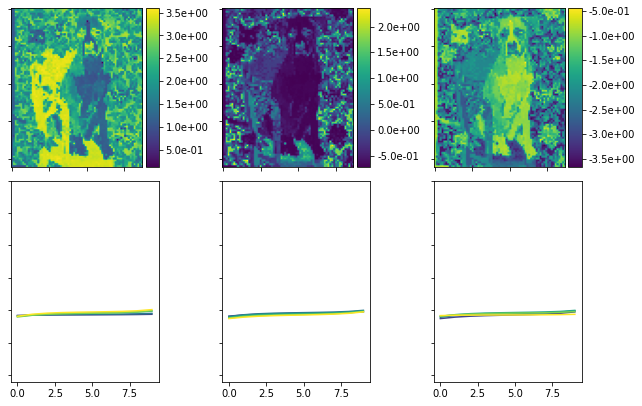

In [ ]:
generate_data(decoder, encoded_spectra, image, 5, 10)

In [19]:
train_iterator = torch.utils.data.DataLoader(X_train,batch_size = 256,shuffle = False)



In [24]:
device = 'cuda' 

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [ ]:
torch.manual_seed(0)
Train(model,encoder,decoder,train_iterator,optimizer,500)

In [27]:
model

Autoencoder(
  (encoder): Encoder(
    (dense_1): Linear(in_features=10, out_features=12, bias=True)
  )
  (decoder): Decoder(
    (dense_1): Linear(in_features=12, out_features=10, bias=True)
  )
)

In [38]:
encoded_spectra = encoder(torch.tensor(dog_data,dtype=torch.float32).to(device))
decoded_spectra = decoder(encoded_spectra)

In [39]:
encoded_spectra = encoded_spectra.to('cpu')
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to('cpu')
decoded_spectra = decoded_spectra.detach().numpy()

In [40]:
maps = encoded_spectra.reshape(image.shape[0], image.shape[1],-1)

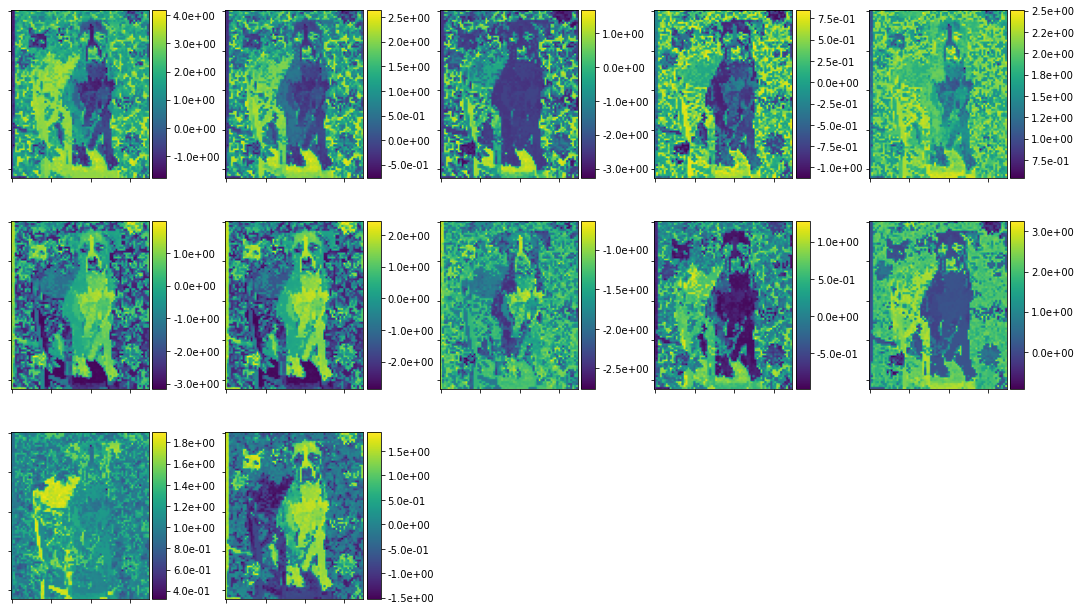

In [41]:
embedding_maps(encoded_spectra, image)

While this captures the features of the image it is still too high-dimensional for detailed interpretation.


**In this case we know we have 3 endmembers set by RGB**

In [44]:
device = 'cuda' 

encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
torch.manual_seed(0)
Train(model,encoder,decoder,train_iterator,optimizer,500)

In [46]:
encoded_spectra = encoder(torch.tensor(dog_data,dtype=torch.float32).to(device))
decoded_spectra = decoder(encoded_spectra)

In [47]:
encoded_spectra = encoded_spectra.to('cpu')
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to('cpu')
decoded_spectra = decoded_spectra.detach().numpy()

In [48]:
maps = encoded_spectra.reshape(image.shape[0], image.shape[1],-1)

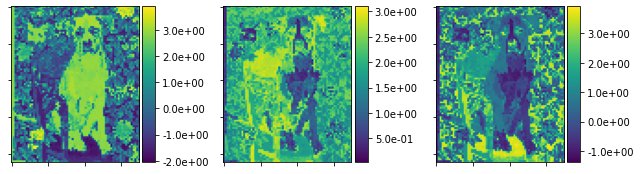

In [49]:
embedding_maps(encoded_spectra, image)

Now we would like to view what the spectra looks like as we generate across the latent space

In [211]:
printing = {'PNG':True,
            'EPS':False, 
           'dpi': 300}

def imagemap(ax, data, colorbars=True, clim=None):
    """
    Plots an image map

    Parameters
    ----------
    axis : matplotlib, object
        axis which is plotted
    data  : numpy, float
        data to plot
    clim  : numpy, float, optional
        sets the climit for the image
    color_bar  : bool, optional
        selects to plot the colorbar bar for the image
    """
    if data.ndim == 1:
        data = data.reshape(np.sqrt(data.shape[0]).astype(
            int), np.sqrt(data.shape[0]).astype(int))

    cmap = plt.get_cmap('viridis')

    if clim is None:
        im = ax.imshow(data,  cmap=cmap)
    else:
        im = ax.imshow(data, clim=clim, cmap=cmap)

    ax.set_yticklabels('')
    ax.set_xticklabels('')

    if colorbars:
        # adds the colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='10%', pad=0.05)
        cbar = plt.colorbar(im, cax=cax, format='%.1e')

def find_nearest(array, value, averaging_number):
    """
    returns the indices nearest to a value in an image
    Parameters
    ----------
    array : float, array
        image to find the index closest to a value
    value : float
        value to find points near
    averaging_number : int
        number of points to find
    """
    idx = (np.abs(array-value)).argsort()[0:averaging_number]
    return idx

def make_folder(folder, **kwargs):
    """
    Function that makes new folders
    Parameters
    ----------'
    folder : string
        folder where to save
    Returns
    -------
    folder : string
        folder where to save
    """

    # Makes folder
    os.makedirs(folder, exist_ok=True)

    return (folder)

def generate_data(model,
                            embeddings,
                            image,
                            number,                            
                            average_number,
                            indx = None,
                            ranges = None,
                            x_values = None,
                            y_scale=[-2.2,4]):
    """
    plots the generator results

    Parameters
    ----------
    model : tensorflow object
        neural network model
    encode : float, array
        the input embedding (or output from encoder)
    voltage : float, array
        voltage array
    number : int
        number of divisions to plot
    averaging_number : int
        number of points to consider in the average
    ranges : float, array
        sets the ranges for the embeddings
    folder : string
        set the folder where to export the images
    plot_format  : dict
        sets the plot format for the images
    printing : dictionary
        contains information for printing
        'dpi': int
            resolution of exported image
        print_EPS : bool
            selects if export the EPS
        print_PNG : bool
            selects if print the PNG
    graph_layout : int, array (optional)
        sets the layout for the figure.

    """

    # sets the colormap
    cmap = plt.cm.viridis

    if indx is None:
      embedding_small = embeddings.squeeze()
    else:
      embedding_small = embeddings[:, indx].squeeze()
    
    
    # creates the figures and axes in a pretty way
    fig, ax = layout_fig(embedding_small.shape[1] * 2, mod = 3)

    # plots all of the embedding maps
    for i in range(embedding_small.shape[1]):

        im = imagemap(ax[i], embedding_small[:, i].reshape(image.shape[0], image.shape[1]))

    # loops around the number of example loops
    for i in range(number):

        # loops around the number of embeddings from the range file
        for j in range(embedding_small.shape[1]):

            if ranges is None:
              value = np.linspace(np.min(embedding_small[:, j]), 
                                  np.max(embedding_small[:, j]), number)
            else:
              # sets the linear spaced values
              value = np.linspace(0, ranges[j], number)

            idx = find_nearest(
                embedding_small[:, j], value[i], average_number)
            gen_value = np.mean(embeddings[idx], axis=0)
            gen_value[j] = value[i]

            # computes the generated results
            gen_value_1 = torch.from_numpy(np.atleast_2d(gen_value)).to(device)
            generated = model(gen_value_1)
            generated = generated.to('cpu')
            generated = generated.detach().numpy().squeeze()
            

            # plots and formats the graphs
            if x_values is None:
              ax[j + embedding_small.shape[1]
                ].plot(generated, color=cmap((i + 1) / number))
            else:
              ax[j + embedding_small.shape[1]
                ].plot(x_values, generated, color=cmap((i + 1) / number))

            ax[j + embedding_small.shape[1]].set_ylim(y_scale)
            ax[j + embedding_small.shape[1]].set_yticklabels('')
            plt.tight_layout(pad=1)

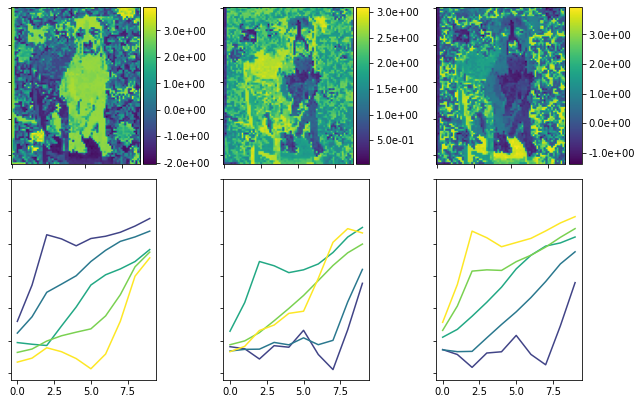

In [54]:
generate_data(decoder, encoded_spectra, image, 5, 10)

# LSTM Version

In [237]:
latent_dim =12
 
 # input (batch,)
class Encoder(nn.Module):
    
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder,self).__init__()
        self.lstm = nn.LSTM(1,12,batch_first=True,bidirectional=True)
        self.embedding = nn.Linear(24,self.latent_dim)
        self.relu = nn.ReLU()


    def forward(self, x):
 #     x = x.transpose(1,2)
      
      x,(_,__) = self.lstm(x)
      x = x[:,-1,:]
      x = self.embedding(x)
      x = self.relu(x)
      return x

class Decoder(nn.Module):
    
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder,self).__init__()
        self.lstm = nn.LSTM(latent_dim,12,batch_first=True,bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
      x = x[:, :, None]
      x = x.transpose(1,2)
      x = x.repeat([1,10,1])
      x,(_,__) = self.lstm(x)
      x = x.transpose(1,2)
      x = self.tdd(x)
      x = x.transpose(1,2)
      return x

In [209]:
device = 'cuda' 

encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [193]:
train_iterator = torch.utils.data.DataLoader(np.atleast_3d(X_train),batch_size = 256,shuffle = False)

In [ ]:
torch.manual_seed(0)
Train(model,encoder,decoder,train_iterator,optimizer,500)

In [195]:
encoded_spectra = encoder(torch.tensor(np.atleast_3d(dog_data),dtype=torch.float32).to(device))
decoded_spectra = decoder(encoded_spectra)

torch.Size([5950, 10, 24])


In [196]:
encoded_spectra = encoded_spectra.to('cpu')
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to('cpu')
decoded_spectra = decoded_spectra.detach().numpy()

In [197]:
maps = encoded_spectra.reshape(image.shape[0], image.shape[1],-1)

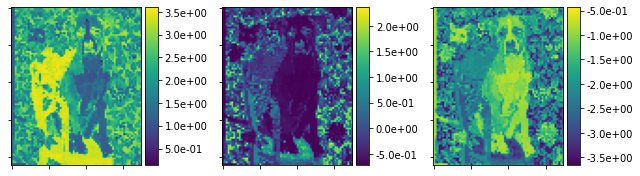

In [198]:
embedding_maps(encoded_spectra, image)

torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])
torch.Size([1, 10, 24])


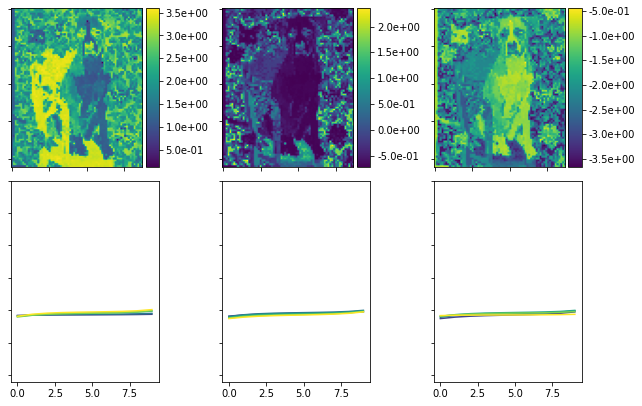

In [214]:
generate_data(decoder, encoded_spectra, image, 5, 10)

# L2 Model

In [238]:
device = 'cuda' 

encoder = Encoder(latent_dim=12).to(device)
decoder = Decoder(latent_dim=12).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [239]:
train_iterator = torch.utils.data.DataLoader(np.atleast_3d(X_train),batch_size = 256,shuffle = False)

In [240]:
torch.manual_seed(0)
Train(model,
      encoder,
      decoder,
      train_iterator,
      optimizer,
      500, 
      coef=1e-4, 
      ln_parm=2)

 42%|████▏     | 8/19 [00:00<00:00, 78.61it/s]

Epoch 0, Train Loss: 1.9674
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.76it/s]

Epoch 1, Train Loss: 1.9276
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.29it/s]

Epoch 2, Train Loss: 1.8868
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.66it/s]

Epoch 3, Train Loss: 1.8413
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.77it/s]

Epoch 4, Train Loss: 1.7874
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.15it/s]

Epoch 5, Train Loss: 1.7162
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.34it/s]

Epoch 6, Train Loss: 1.6179
.............................


 47%|████▋     | 9/19 [00:00<00:00, 79.97it/s]

Epoch 7, Train Loss: 1.4735
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.83it/s]

Epoch 8, Train Loss: 1.2631
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.71it/s]

Epoch 9, Train Loss: 0.9998
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.94it/s]

Epoch 10, Train Loss: 0.7492
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.73it/s]

Epoch 11, Train Loss: 0.5544
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.68it/s]

Epoch 12, Train Loss: 0.4095
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.55it/s]

Epoch 13, Train Loss: 0.3123
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.71it/s]

Epoch 14, Train Loss: 0.2550
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.29it/s]

Epoch 15, Train Loss: 0.2255
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.96it/s]

Epoch 16, Train Loss: 0.2109
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.15it/s]

Epoch 17, Train Loss: 0.2025
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.55it/s]

Epoch 18, Train Loss: 0.1963
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.27it/s]

Epoch 19, Train Loss: 0.1913
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.38it/s]

Epoch 20, Train Loss: 0.1869
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.52it/s]

Epoch 21, Train Loss: 0.1830
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.02it/s]

Epoch 22, Train Loss: 0.1794
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.98it/s]

Epoch 23, Train Loss: 0.1760
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.49it/s]

Epoch 24, Train Loss: 0.1727
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.53it/s]

Epoch 25, Train Loss: 0.1696
.............................


 37%|███▋      | 7/19 [00:00<00:00, 61.15it/s]

Epoch 26, Train Loss: 0.1666
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.82it/s]

Epoch 27, Train Loss: 0.1638
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.95it/s]

Epoch 28, Train Loss: 0.1611
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.35it/s]

Epoch 29, Train Loss: 0.1585
.............................


 32%|███▏      | 6/19 [00:00<00:00, 59.11it/s]

Epoch 30, Train Loss: 0.1560
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.24it/s]

Epoch 31, Train Loss: 0.1535
.............................


 37%|███▋      | 7/19 [00:00<00:00, 60.95it/s]

Epoch 32, Train Loss: 0.1512
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.70it/s]

Epoch 33, Train Loss: 0.1489
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.40it/s]

Epoch 34, Train Loss: 0.1468
.............................


 47%|████▋     | 9/19 [00:00<00:00, 79.04it/s]

Epoch 35, Train Loss: 0.1447
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.39it/s]

Epoch 36, Train Loss: 0.1428
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.14it/s]

Epoch 37, Train Loss: 0.1409
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.70it/s]

Epoch 38, Train Loss: 0.1391
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.22it/s]

Epoch 39, Train Loss: 0.1375
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.12it/s]

Epoch 40, Train Loss: 0.1359
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.71it/s]

Epoch 41, Train Loss: 0.1345
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.90it/s]

Epoch 42, Train Loss: 0.1332
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.80it/s]

Epoch 43, Train Loss: 0.1319
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.64it/s]

Epoch 44, Train Loss: 0.1307
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.50it/s]

Epoch 45, Train Loss: 0.1297
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.57it/s]

Epoch 46, Train Loss: 0.1286
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.65it/s]

Epoch 47, Train Loss: 0.1276
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.77it/s]

Epoch 48, Train Loss: 0.1267
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.31it/s]

Epoch 49, Train Loss: 0.1258
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.00it/s]

Epoch 50, Train Loss: 0.1249
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.55it/s]

Epoch 51, Train Loss: 0.1241
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.75it/s]

Epoch 52, Train Loss: 0.1233
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.17it/s]

Epoch 53, Train Loss: 0.1225
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.59it/s]

Epoch 54, Train Loss: 0.1217
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.50it/s]

Epoch 55, Train Loss: 0.1209
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.16it/s]

Epoch 56, Train Loss: 0.1201
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.95it/s]

Epoch 57, Train Loss: 0.1194
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.92it/s]

Epoch 58, Train Loss: 0.1186
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.52it/s]

Epoch 59, Train Loss: 0.1178
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.07it/s]

Epoch 60, Train Loss: 0.1169
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.18it/s]

Epoch 61, Train Loss: 0.1161
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.09it/s]

Epoch 62, Train Loss: 0.1152
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.53it/s]

Epoch 63, Train Loss: 0.1143
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.12it/s]

Epoch 64, Train Loss: 0.1135
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.10it/s]

Epoch 65, Train Loss: 0.1126
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.06it/s]

Epoch 66, Train Loss: 0.1117
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.92it/s]

Epoch 67, Train Loss: 0.1108
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.86it/s]

Epoch 68, Train Loss: 0.1099
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.37it/s]

Epoch 69, Train Loss: 0.1090
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.66it/s]

Epoch 70, Train Loss: 0.1081
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.36it/s]

Epoch 71, Train Loss: 0.1071
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.82it/s]

Epoch 72, Train Loss: 0.1061
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.57it/s]

Epoch 73, Train Loss: 0.1050
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.46it/s]

Epoch 74, Train Loss: 0.1040
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.13it/s]

Epoch 75, Train Loss: 0.1029
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.73it/s]

Epoch 76, Train Loss: 0.1018
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.01it/s]

Epoch 77, Train Loss: 0.1006
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.59it/s]

Epoch 78, Train Loss: 0.0995
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.42it/s]

Epoch 79, Train Loss: 0.0982
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.55it/s]

Epoch 80, Train Loss: 0.0970
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.72it/s]

Epoch 81, Train Loss: 0.0957
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.34it/s]

Epoch 82, Train Loss: 0.0943
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.06it/s]

Epoch 83, Train Loss: 0.0930
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.07it/s]

Epoch 84, Train Loss: 0.0915
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.91it/s]

Epoch 85, Train Loss: 0.0901
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.77it/s]

Epoch 86, Train Loss: 0.0886
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.71it/s]

Epoch 87, Train Loss: 0.0871
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.82it/s]

Epoch 88, Train Loss: 0.0855
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.25it/s]

Epoch 89, Train Loss: 0.0840
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.54it/s]

Epoch 90, Train Loss: 0.0825
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.54it/s]

Epoch 91, Train Loss: 0.0809
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.02it/s]

Epoch 92, Train Loss: 0.0794
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.09it/s]

Epoch 93, Train Loss: 0.0780
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.38it/s]

Epoch 94, Train Loss: 0.0765
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.75it/s]

Epoch 95, Train Loss: 0.0751
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.24it/s]

Epoch 96, Train Loss: 0.0736
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.10it/s]

Epoch 97, Train Loss: 0.0722
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.14it/s]

Epoch 98, Train Loss: 0.0707
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.74it/s]

Epoch 99, Train Loss: 0.0693
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.18it/s]

Epoch 100, Train Loss: 0.0678
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.96it/s]

Epoch 101, Train Loss: 0.0664
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.59it/s]

Epoch 102, Train Loss: 0.0650
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.92it/s]

Epoch 103, Train Loss: 0.0638
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.38it/s]

Epoch 104, Train Loss: 0.0626
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.93it/s]

Epoch 105, Train Loss: 0.0615
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.56it/s]

Epoch 106, Train Loss: 0.0605
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.43it/s]

Epoch 107, Train Loss: 0.0596
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.74it/s]

Epoch 108, Train Loss: 0.0586
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.48it/s]

Epoch 109, Train Loss: 0.0577
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.15it/s]

Epoch 110, Train Loss: 0.0568
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.99it/s]

Epoch 111, Train Loss: 0.0560
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.95it/s]

Epoch 112, Train Loss: 0.0551
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.48it/s]

Epoch 113, Train Loss: 0.0542
.............................


 37%|███▋      | 7/19 [00:00<00:00, 61.92it/s]

Epoch 114, Train Loss: 0.0533
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.41it/s]

Epoch 115, Train Loss: 0.0524
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.51it/s]

Epoch 116, Train Loss: 0.0516
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.47it/s]

Epoch 117, Train Loss: 0.0507
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.19it/s]

Epoch 118, Train Loss: 0.0499
.............................


 32%|███▏      | 6/19 [00:00<00:00, 57.92it/s]

Epoch 119, Train Loss: 0.0491
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.34it/s]

Epoch 120, Train Loss: 0.0483
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.06it/s]

Epoch 121, Train Loss: 0.0475
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.91it/s]

Epoch 122, Train Loss: 0.0467
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.94it/s]

Epoch 123, Train Loss: 0.0458
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.54it/s]

Epoch 124, Train Loss: 0.0450
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.15it/s]

Epoch 125, Train Loss: 0.0441
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.47it/s]

Epoch 126, Train Loss: 0.0432
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.79it/s]

Epoch 127, Train Loss: 0.0423
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.97it/s]

Epoch 128, Train Loss: 0.0414
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.70it/s]

Epoch 129, Train Loss: 0.0406
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.97it/s]

Epoch 130, Train Loss: 0.0398
.............................


 32%|███▏      | 6/19 [00:00<00:00, 59.36it/s]

Epoch 131, Train Loss: 0.0390
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.46it/s]

Epoch 132, Train Loss: 0.0383
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.72it/s]

Epoch 133, Train Loss: 0.0376
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.57it/s]

Epoch 134, Train Loss: 0.0370
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.79it/s]

Epoch 135, Train Loss: 0.0363
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.52it/s]

Epoch 136, Train Loss: 0.0357
.............................


 37%|███▋      | 7/19 [00:00<00:00, 61.67it/s]

Epoch 137, Train Loss: 0.0351
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.86it/s]

Epoch 138, Train Loss: 0.0346
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.92it/s]

Epoch 139, Train Loss: 0.0340
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.40it/s]

Epoch 140, Train Loss: 0.0335
.............................


 37%|███▋      | 7/19 [00:00<00:00, 61.13it/s]

Epoch 141, Train Loss: 0.0330
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.70it/s]

Epoch 142, Train Loss: 0.0325
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.63it/s]

Epoch 143, Train Loss: 0.0321
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.67it/s]

Epoch 144, Train Loss: 0.0317
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.31it/s]

Epoch 145, Train Loss: 0.0312
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.07it/s]

Epoch 146, Train Loss: 0.0308
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.24it/s]

Epoch 147, Train Loss: 0.0305
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.33it/s]

Epoch 148, Train Loss: 0.0301
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.37it/s]

Epoch 149, Train Loss: 0.0297
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.97it/s]

Epoch 150, Train Loss: 0.0294
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.90it/s]

Epoch 151, Train Loss: 0.0291
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.62it/s]

Epoch 152, Train Loss: 0.0288
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.98it/s]

Epoch 153, Train Loss: 0.0284
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.57it/s]

Epoch 154, Train Loss: 0.0281
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.30it/s]

Epoch 155, Train Loss: 0.0278
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.06it/s]

Epoch 156, Train Loss: 0.0276
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.87it/s]

Epoch 157, Train Loss: 0.0273
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.23it/s]

Epoch 158, Train Loss: 0.0270
.............................


 37%|███▋      | 7/19 [00:00<00:00, 60.86it/s]

Epoch 159, Train Loss: 0.0268
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.76it/s]

Epoch 160, Train Loss: 0.0265
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.85it/s]

Epoch 161, Train Loss: 0.0263
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.34it/s]

Epoch 162, Train Loss: 0.0261
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.59it/s]

Epoch 163, Train Loss: 0.0258
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.87it/s]

Epoch 164, Train Loss: 0.0256
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.60it/s]

Epoch 165, Train Loss: 0.0254
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.92it/s]

Epoch 166, Train Loss: 0.0252
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.52it/s]

Epoch 167, Train Loss: 0.0250
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.74it/s]

Epoch 168, Train Loss: 0.0248
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.31it/s]

Epoch 169, Train Loss: 0.0247
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.26it/s]

Epoch 170, Train Loss: 0.0245
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.47it/s]

Epoch 171, Train Loss: 0.0243
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.20it/s]

Epoch 172, Train Loss: 0.0241
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.32it/s]

Epoch 173, Train Loss: 0.0240
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.92it/s]

Epoch 174, Train Loss: 0.0238
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.68it/s]

Epoch 175, Train Loss: 0.0237
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.75it/s]

Epoch 176, Train Loss: 0.0235
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.93it/s]

Epoch 177, Train Loss: 0.0234
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.98it/s]

Epoch 178, Train Loss: 0.0232
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.23it/s]

Epoch 179, Train Loss: 0.0231
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.08it/s]

Epoch 180, Train Loss: 0.0229
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.86it/s]

Epoch 181, Train Loss: 0.0228
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.23it/s]

Epoch 182, Train Loss: 0.0227
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.65it/s]

Epoch 183, Train Loss: 0.0226
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.27it/s]

Epoch 184, Train Loss: 0.0224
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.10it/s]

Epoch 185, Train Loss: 0.0223
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.25it/s]

Epoch 186, Train Loss: 0.0222
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.76it/s]

Epoch 187, Train Loss: 0.0221
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.45it/s]

Epoch 188, Train Loss: 0.0220
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.62it/s]

Epoch 189, Train Loss: 0.0219
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.09it/s]

Epoch 190, Train Loss: 0.0218
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.64it/s]

Epoch 191, Train Loss: 0.0217
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.30it/s]

Epoch 192, Train Loss: 0.0215
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.22it/s]

Epoch 193, Train Loss: 0.0214
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.90it/s]

Epoch 194, Train Loss: 0.0213
.............................


 32%|███▏      | 6/19 [00:00<00:00, 59.20it/s]

Epoch 195, Train Loss: 0.0213
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.22it/s]

Epoch 196, Train Loss: 0.0212
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.86it/s]

Epoch 197, Train Loss: 0.0211
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.08it/s]

Epoch 198, Train Loss: 0.0210
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.04it/s]

Epoch 199, Train Loss: 0.0209
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.87it/s]

Epoch 200, Train Loss: 0.0208
.............................


 37%|███▋      | 7/19 [00:00<00:00, 60.86it/s]

Epoch 201, Train Loss: 0.0207
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.59it/s]

Epoch 202, Train Loss: 0.0206
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.42it/s]

Epoch 203, Train Loss: 0.0205
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.23it/s]

Epoch 204, Train Loss: 0.0204
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.78it/s]

Epoch 205, Train Loss: 0.0203
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.24it/s]

Epoch 206, Train Loss: 0.0203
.............................


 32%|███▏      | 6/19 [00:00<00:00, 59.29it/s]

Epoch 207, Train Loss: 0.0202
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.16it/s]

Epoch 208, Train Loss: 0.0201
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.16it/s]

Epoch 209, Train Loss: 0.0200
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.90it/s]

Epoch 210, Train Loss: 0.0199
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.51it/s]

Epoch 211, Train Loss: 0.0198
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.00it/s]

Epoch 212, Train Loss: 0.0198
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.40it/s]

Epoch 213, Train Loss: 0.0197
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.76it/s]

Epoch 214, Train Loss: 0.0196
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.54it/s]

Epoch 215, Train Loss: 0.0195
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.99it/s]

Epoch 216, Train Loss: 0.0194
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.29it/s]

Epoch 217, Train Loss: 0.0194
.............................


 47%|████▋     | 9/19 [00:00<00:00, 79.34it/s]

Epoch 218, Train Loss: 0.0193
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.66it/s]

Epoch 219, Train Loss: 0.0192
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.89it/s]

Epoch 220, Train Loss: 0.0191
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.88it/s]

Epoch 221, Train Loss: 0.0191
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.79it/s]

Epoch 222, Train Loss: 0.0190
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.28it/s]

Epoch 223, Train Loss: 0.0189
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.11it/s]

Epoch 224, Train Loss: 0.0188
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.97it/s]

Epoch 225, Train Loss: 0.0188
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.30it/s]

Epoch 226, Train Loss: 0.0187
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.52it/s]

Epoch 227, Train Loss: 0.0186
.............................


 47%|████▋     | 9/19 [00:00<00:00, 79.73it/s]

Epoch 228, Train Loss: 0.0186
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.97it/s]

Epoch 229, Train Loss: 0.0185
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.76it/s]

Epoch 230, Train Loss: 0.0184
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.89it/s]

Epoch 231, Train Loss: 0.0184
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.39it/s]

Epoch 232, Train Loss: 0.0183
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.72it/s]

Epoch 233, Train Loss: 0.0182
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.39it/s]

Epoch 234, Train Loss: 0.0182
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.09it/s]

Epoch 235, Train Loss: 0.0181
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.60it/s]

Epoch 236, Train Loss: 0.0180
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.57it/s]

Epoch 237, Train Loss: 0.0180
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.86it/s]

Epoch 238, Train Loss: 0.0179
.............................


 37%|███▋      | 7/19 [00:00<00:00, 61.52it/s]

Epoch 239, Train Loss: 0.0178
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.81it/s]

Epoch 240, Train Loss: 0.0178
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.16it/s]

Epoch 241, Train Loss: 0.0177
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.14it/s]

Epoch 242, Train Loss: 0.0176
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.01it/s]

Epoch 243, Train Loss: 0.0176
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.09it/s]

Epoch 244, Train Loss: 0.0175
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.48it/s]

Epoch 245, Train Loss: 0.0175
.............................


 37%|███▋      | 7/19 [00:00<00:00, 61.90it/s]

Epoch 246, Train Loss: 0.0174
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.89it/s]

Epoch 247, Train Loss: 0.0173
.............................


 32%|███▏      | 6/19 [00:00<00:00, 56.88it/s]

Epoch 248, Train Loss: 0.0173
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.35it/s]

Epoch 249, Train Loss: 0.0172
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.43it/s]

Epoch 250, Train Loss: 0.0172
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.60it/s]

Epoch 251, Train Loss: 0.0171
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.17it/s]

Epoch 252, Train Loss: 0.0171
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.66it/s]

Epoch 253, Train Loss: 0.0170
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.62it/s]

Epoch 254, Train Loss: 0.0169
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.27it/s]

Epoch 255, Train Loss: 0.0169
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.49it/s]

Epoch 256, Train Loss: 0.0168
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.64it/s]

Epoch 257, Train Loss: 0.0168
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.32it/s]

Epoch 258, Train Loss: 0.0167
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.80it/s]

Epoch 259, Train Loss: 0.0167
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.07it/s]

Epoch 260, Train Loss: 0.0166
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.25it/s]

Epoch 261, Train Loss: 0.0166
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.58it/s]

Epoch 262, Train Loss: 0.0165
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.21it/s]

Epoch 263, Train Loss: 0.0165
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.82it/s]

Epoch 264, Train Loss: 0.0164
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.88it/s]

Epoch 265, Train Loss: 0.0164
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.39it/s]

Epoch 266, Train Loss: 0.0163
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.27it/s]

Epoch 267, Train Loss: 0.0163
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.96it/s]

Epoch 268, Train Loss: 0.0162
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.30it/s]

Epoch 269, Train Loss: 0.0162
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.34it/s]

Epoch 270, Train Loss: 0.0161
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.44it/s]

Epoch 271, Train Loss: 0.0161
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.19it/s]

Epoch 272, Train Loss: 0.0160
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.38it/s]

Epoch 273, Train Loss: 0.0160
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.83it/s]

Epoch 274, Train Loss: 0.0159
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.31it/s]

Epoch 275, Train Loss: 0.0159
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.61it/s]

Epoch 276, Train Loss: 0.0158
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.73it/s]

Epoch 277, Train Loss: 0.0158
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.95it/s]

Epoch 278, Train Loss: 0.0157
.............................


 37%|███▋      | 7/19 [00:00<00:00, 67.67it/s]

Epoch 279, Train Loss: 0.0157
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.88it/s]

Epoch 280, Train Loss: 0.0157
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.92it/s]

Epoch 281, Train Loss: 0.0156
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.67it/s]

Epoch 282, Train Loss: 0.0156
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.07it/s]

Epoch 283, Train Loss: 0.0155
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.35it/s]

Epoch 284, Train Loss: 0.0155
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.96it/s]

Epoch 285, Train Loss: 0.0154
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.17it/s]

Epoch 286, Train Loss: 0.0154
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.53it/s]

Epoch 287, Train Loss: 0.0154
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.30it/s]

Epoch 288, Train Loss: 0.0153
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.37it/s]

Epoch 289, Train Loss: 0.0153
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.04it/s]

Epoch 290, Train Loss: 0.0152
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.12it/s]

Epoch 291, Train Loss: 0.0152
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.10it/s]

Epoch 292, Train Loss: 0.0152
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.54it/s]

Epoch 293, Train Loss: 0.0151
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.12it/s]

Epoch 294, Train Loss: 0.0151
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.08it/s]

Epoch 295, Train Loss: 0.0151
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.69it/s]

Epoch 296, Train Loss: 0.0150
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.94it/s]

Epoch 297, Train Loss: 0.0150
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.22it/s]

Epoch 298, Train Loss: 0.0149
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.56it/s]

Epoch 299, Train Loss: 0.0149
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.80it/s]

Epoch 300, Train Loss: 0.0149
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.66it/s]

Epoch 301, Train Loss: 0.0148
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.77it/s]

Epoch 302, Train Loss: 0.0148
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.35it/s]

Epoch 303, Train Loss: 0.0148
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.73it/s]

Epoch 304, Train Loss: 0.0147
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.41it/s]

Epoch 305, Train Loss: 0.0147
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.73it/s]

Epoch 306, Train Loss: 0.0147
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.16it/s]

Epoch 307, Train Loss: 0.0146
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.48it/s]

Epoch 308, Train Loss: 0.0146
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.58it/s]

Epoch 309, Train Loss: 0.0146
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.52it/s]

Epoch 310, Train Loss: 0.0145
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.61it/s]

Epoch 311, Train Loss: 0.0145
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.70it/s]

Epoch 312, Train Loss: 0.0145
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.61it/s]

Epoch 313, Train Loss: 0.0144
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.27it/s]

Epoch 314, Train Loss: 0.0144
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.21it/s]

Epoch 315, Train Loss: 0.0144
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.38it/s]

Epoch 316, Train Loss: 0.0143
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.81it/s]

Epoch 317, Train Loss: 0.0143
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.90it/s]

Epoch 318, Train Loss: 0.0143
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.33it/s]

Epoch 319, Train Loss: 0.0142
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.44it/s]

Epoch 320, Train Loss: 0.0142
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.46it/s]

Epoch 321, Train Loss: 0.0142
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.04it/s]

Epoch 322, Train Loss: 0.0141
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.49it/s]

Epoch 323, Train Loss: 0.0141
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.55it/s]

Epoch 324, Train Loss: 0.0141
.............................


 37%|███▋      | 7/19 [00:00<00:00, 67.27it/s]

Epoch 325, Train Loss: 0.0140
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.28it/s]

Epoch 326, Train Loss: 0.0140
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.83it/s]

Epoch 327, Train Loss: 0.0140
.............................


 37%|███▋      | 7/19 [00:00<00:00, 61.38it/s]

Epoch 328, Train Loss: 0.0139
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.87it/s]

Epoch 329, Train Loss: 0.0139
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.21it/s]

Epoch 330, Train Loss: 0.0139
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.09it/s]

Epoch 331, Train Loss: 0.0139
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.68it/s]

Epoch 332, Train Loss: 0.0138
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.82it/s]

Epoch 333, Train Loss: 0.0138
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.15it/s]

Epoch 334, Train Loss: 0.0138
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.63it/s]

Epoch 335, Train Loss: 0.0137
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.41it/s]

Epoch 336, Train Loss: 0.0137
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.81it/s]

Epoch 337, Train Loss: 0.0137
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.27it/s]

Epoch 338, Train Loss: 0.0136
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.74it/s]

Epoch 339, Train Loss: 0.0136
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.68it/s]

Epoch 340, Train Loss: 0.0136
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.66it/s]

Epoch 341, Train Loss: 0.0136
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.99it/s]

Epoch 342, Train Loss: 0.0135
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.92it/s]

Epoch 343, Train Loss: 0.0135
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.61it/s]

Epoch 344, Train Loss: 0.0135
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.27it/s]

Epoch 345, Train Loss: 0.0134
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.08it/s]

Epoch 346, Train Loss: 0.0134
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.47it/s]

Epoch 347, Train Loss: 0.0134
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.40it/s]

Epoch 348, Train Loss: 0.0134
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.51it/s]

Epoch 349, Train Loss: 0.0133
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.49it/s]

Epoch 350, Train Loss: 0.0133
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.29it/s]

Epoch 351, Train Loss: 0.0133
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.25it/s]

Epoch 352, Train Loss: 0.0132
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.53it/s]

Epoch 353, Train Loss: 0.0132
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.20it/s]

Epoch 354, Train Loss: 0.0132
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.85it/s]

Epoch 355, Train Loss: 0.0132
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.58it/s]

Epoch 356, Train Loss: 0.0131
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.73it/s]

Epoch 357, Train Loss: 0.0131
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.25it/s]

Epoch 358, Train Loss: 0.0131
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.69it/s]

Epoch 359, Train Loss: 0.0131
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.70it/s]

Epoch 360, Train Loss: 0.0130
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.12it/s]

Epoch 361, Train Loss: 0.0130
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.01it/s]

Epoch 362, Train Loss: 0.0130
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.54it/s]

Epoch 363, Train Loss: 0.0129
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.19it/s]

Epoch 364, Train Loss: 0.0129
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.10it/s]

Epoch 365, Train Loss: 0.0129
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.90it/s]

Epoch 366, Train Loss: 0.0129
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.90it/s]

Epoch 367, Train Loss: 0.0128
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.11it/s]

Epoch 368, Train Loss: 0.0128
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.94it/s]

Epoch 369, Train Loss: 0.0128
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.79it/s]

Epoch 370, Train Loss: 0.0128
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.14it/s]

Epoch 371, Train Loss: 0.0127
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.38it/s]

Epoch 372, Train Loss: 0.0127
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.29it/s]

Epoch 373, Train Loss: 0.0127
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.42it/s]

Epoch 374, Train Loss: 0.0127
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.07it/s]

Epoch 375, Train Loss: 0.0126
.............................


 32%|███▏      | 6/19 [00:00<00:00, 59.53it/s]

Epoch 376, Train Loss: 0.0126
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.98it/s]

Epoch 377, Train Loss: 0.0126
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.91it/s]

Epoch 378, Train Loss: 0.0125
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.20it/s]

Epoch 379, Train Loss: 0.0125
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.15it/s]

Epoch 380, Train Loss: 0.0125
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.20it/s]

Epoch 381, Train Loss: 0.0125
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.60it/s]

Epoch 382, Train Loss: 0.0124
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.80it/s]

Epoch 383, Train Loss: 0.0124
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.98it/s]

Epoch 384, Train Loss: 0.0124
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.01it/s]

Epoch 385, Train Loss: 0.0124
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.45it/s]

Epoch 386, Train Loss: 0.0123
.............................


 32%|███▏      | 6/19 [00:00<00:00, 58.89it/s]

Epoch 387, Train Loss: 0.0123
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.53it/s]

Epoch 388, Train Loss: 0.0123
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.51it/s]

Epoch 389, Train Loss: 0.0123
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.94it/s]

Epoch 390, Train Loss: 0.0122
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.82it/s]

Epoch 391, Train Loss: 0.0122
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.51it/s]

Epoch 392, Train Loss: 0.0122
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.41it/s]

Epoch 393, Train Loss: 0.0122
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.06it/s]

Epoch 394, Train Loss: 0.0121
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.49it/s]

Epoch 395, Train Loss: 0.0121
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.46it/s]

Epoch 396, Train Loss: 0.0121
.............................


 32%|███▏      | 6/19 [00:00<00:00, 59.43it/s]

Epoch 397, Train Loss: 0.0121
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.16it/s]

Epoch 398, Train Loss: 0.0120
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.57it/s]

Epoch 399, Train Loss: 0.0120
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.34it/s]

Epoch 400, Train Loss: 0.0120
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.55it/s]

Epoch 401, Train Loss: 0.0120
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.12it/s]

Epoch 402, Train Loss: 0.0119
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.09it/s]

Epoch 403, Train Loss: 0.0119
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.54it/s]

Epoch 404, Train Loss: 0.0119
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.60it/s]

Epoch 405, Train Loss: 0.0119
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.96it/s]

Epoch 406, Train Loss: 0.0118
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.36it/s]

Epoch 407, Train Loss: 0.0118
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.52it/s]

Epoch 408, Train Loss: 0.0118
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.34it/s]

Epoch 409, Train Loss: 0.0117
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.62it/s]

Epoch 410, Train Loss: 0.0117
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.80it/s]

Epoch 411, Train Loss: 0.0117
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.84it/s]

Epoch 412, Train Loss: 0.0117
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.91it/s]

Epoch 413, Train Loss: 0.0117
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.96it/s]

Epoch 414, Train Loss: 0.0116
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.46it/s]

Epoch 415, Train Loss: 0.0116
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.85it/s]

Epoch 416, Train Loss: 0.0116
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.07it/s]

Epoch 417, Train Loss: 0.0116
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.57it/s]

Epoch 418, Train Loss: 0.0115
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.74it/s]

Epoch 419, Train Loss: 0.0115
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.75it/s]

Epoch 420, Train Loss: 0.0115
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.19it/s]

Epoch 421, Train Loss: 0.0115
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.66it/s]

Epoch 422, Train Loss: 0.0114
.............................


 32%|███▏      | 6/19 [00:00<00:00, 56.09it/s]

Epoch 423, Train Loss: 0.0114
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.63it/s]

Epoch 424, Train Loss: 0.0114
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.29it/s]

Epoch 425, Train Loss: 0.0114
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.45it/s]

Epoch 426, Train Loss: 0.0113
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.88it/s]

Epoch 427, Train Loss: 0.0113
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.01it/s]

Epoch 428, Train Loss: 0.0113
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.54it/s]

Epoch 429, Train Loss: 0.0113
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.88it/s]

Epoch 430, Train Loss: 0.0112
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.48it/s]

Epoch 431, Train Loss: 0.0112
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.78it/s]

Epoch 432, Train Loss: 0.0112
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.12it/s]

Epoch 433, Train Loss: 0.0112
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.35it/s]

Epoch 434, Train Loss: 0.0111
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.72it/s]

Epoch 435, Train Loss: 0.0111
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.45it/s]

Epoch 436, Train Loss: 0.0111
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.42it/s]

Epoch 437, Train Loss: 0.0111
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.15it/s]

Epoch 438, Train Loss: 0.0110
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.28it/s]

Epoch 439, Train Loss: 0.0110
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.79it/s]

Epoch 440, Train Loss: 0.0110
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.77it/s]

Epoch 441, Train Loss: 0.0110
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.67it/s]

Epoch 442, Train Loss: 0.0110
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.79it/s]

Epoch 443, Train Loss: 0.0109
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.06it/s]

Epoch 444, Train Loss: 0.0109
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.17it/s]

Epoch 445, Train Loss: 0.0109
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.80it/s]

Epoch 446, Train Loss: 0.0109
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.21it/s]

Epoch 447, Train Loss: 0.0108
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.53it/s]

Epoch 448, Train Loss: 0.0108
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.53it/s]

Epoch 449, Train Loss: 0.0108
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.65it/s]

Epoch 450, Train Loss: 0.0108
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.33it/s]

Epoch 451, Train Loss: 0.0107
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.51it/s]

Epoch 452, Train Loss: 0.0107
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.69it/s]

Epoch 453, Train Loss: 0.0107
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.91it/s]

Epoch 454, Train Loss: 0.0107
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.65it/s]

Epoch 455, Train Loss: 0.0107
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.27it/s]

Epoch 456, Train Loss: 0.0106
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.52it/s]

Epoch 457, Train Loss: 0.0106
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.36it/s]

Epoch 458, Train Loss: 0.0106
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.14it/s]

Epoch 459, Train Loss: 0.0106
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.63it/s]

Epoch 460, Train Loss: 0.0105
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.18it/s]

Epoch 461, Train Loss: 0.0105
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.80it/s]

Epoch 462, Train Loss: 0.0105
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.73it/s]

Epoch 463, Train Loss: 0.0105
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.99it/s]

Epoch 464, Train Loss: 0.0105
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.40it/s]

Epoch 465, Train Loss: 0.0104
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.39it/s]

Epoch 466, Train Loss: 0.0104
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.39it/s]

Epoch 467, Train Loss: 0.0104
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.48it/s]

Epoch 468, Train Loss: 0.0104
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.62it/s]

Epoch 469, Train Loss: 0.0104
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.08it/s]

Epoch 470, Train Loss: 0.0103
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.91it/s]

Epoch 471, Train Loss: 0.0103
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.81it/s]

Epoch 472, Train Loss: 0.0103
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.62it/s]

Epoch 473, Train Loss: 0.0103
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.33it/s]

Epoch 474, Train Loss: 0.0102
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.78it/s]

Epoch 475, Train Loss: 0.0102
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.87it/s]

Epoch 476, Train Loss: 0.0102
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.71it/s]

Epoch 477, Train Loss: 0.0102
.............................


 32%|███▏      | 6/19 [00:00<00:00, 58.58it/s]

Epoch 478, Train Loss: 0.0102
.............................


 32%|███▏      | 6/19 [00:00<00:00, 59.38it/s]

Epoch 479, Train Loss: 0.0101
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.00it/s]

Epoch 480, Train Loss: 0.0101
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.43it/s]

Epoch 481, Train Loss: 0.0101
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.41it/s]

Epoch 482, Train Loss: 0.0101
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.24it/s]

Epoch 483, Train Loss: 0.0101
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.73it/s]

Epoch 484, Train Loss: 0.0100
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.67it/s]

Epoch 485, Train Loss: 0.0100
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.87it/s]

Epoch 486, Train Loss: 0.0100
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.73it/s]

Epoch 487, Train Loss: 0.0100
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.85it/s]

Epoch 488, Train Loss: 0.0100
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.19it/s]

Epoch 489, Train Loss: 0.0099
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.49it/s]

Epoch 490, Train Loss: 0.0099
.............................


 42%|████▏     | 8/19 [00:00<00:00, 68.52it/s]

Epoch 491, Train Loss: 0.0099
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.72it/s]

Epoch 492, Train Loss: 0.0099
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.55it/s]

Epoch 493, Train Loss: 0.0099
.............................


 32%|███▏      | 6/19 [00:00<00:00, 57.71it/s]

Epoch 494, Train Loss: 0.0098
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.65it/s]

Epoch 495, Train Loss: 0.0098
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.23it/s]

Epoch 496, Train Loss: 0.0098
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.13it/s]

Epoch 497, Train Loss: 0.0098
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.22it/s]

Epoch 498, Train Loss: 0.0098
.............................


100%|██████████| 19/19 [00:00<00:00, 74.06it/s]

Epoch 499, Train Loss: 0.0097
.............................


In [241]:
encoded_spectra = encoder(torch.tensor(np.atleast_3d(dog_data),dtype=torch.float32).to(device))
decoded_spectra = decoder(encoded_spectra)

In [242]:
encoded_spectra = encoded_spectra.to('cpu')
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to('cpu')
decoded_spectra = decoded_spectra.detach().numpy()

In [243]:
maps = encoded_spectra.reshape(image.shape[0], image.shape[1],-1)

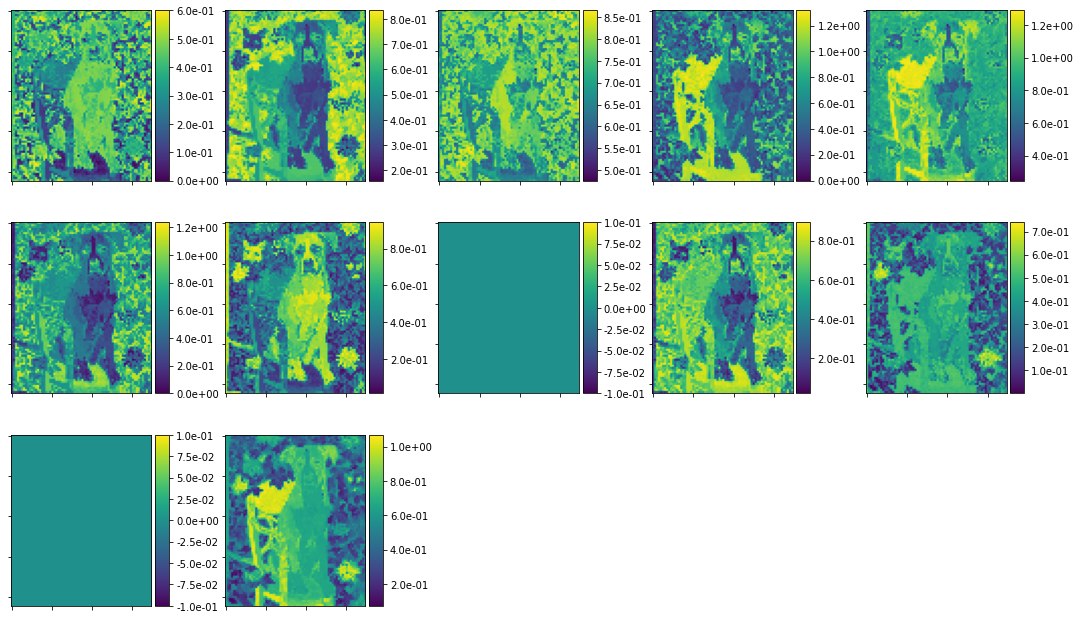

In [244]:
embedding_maps(encoded_spectra, image)

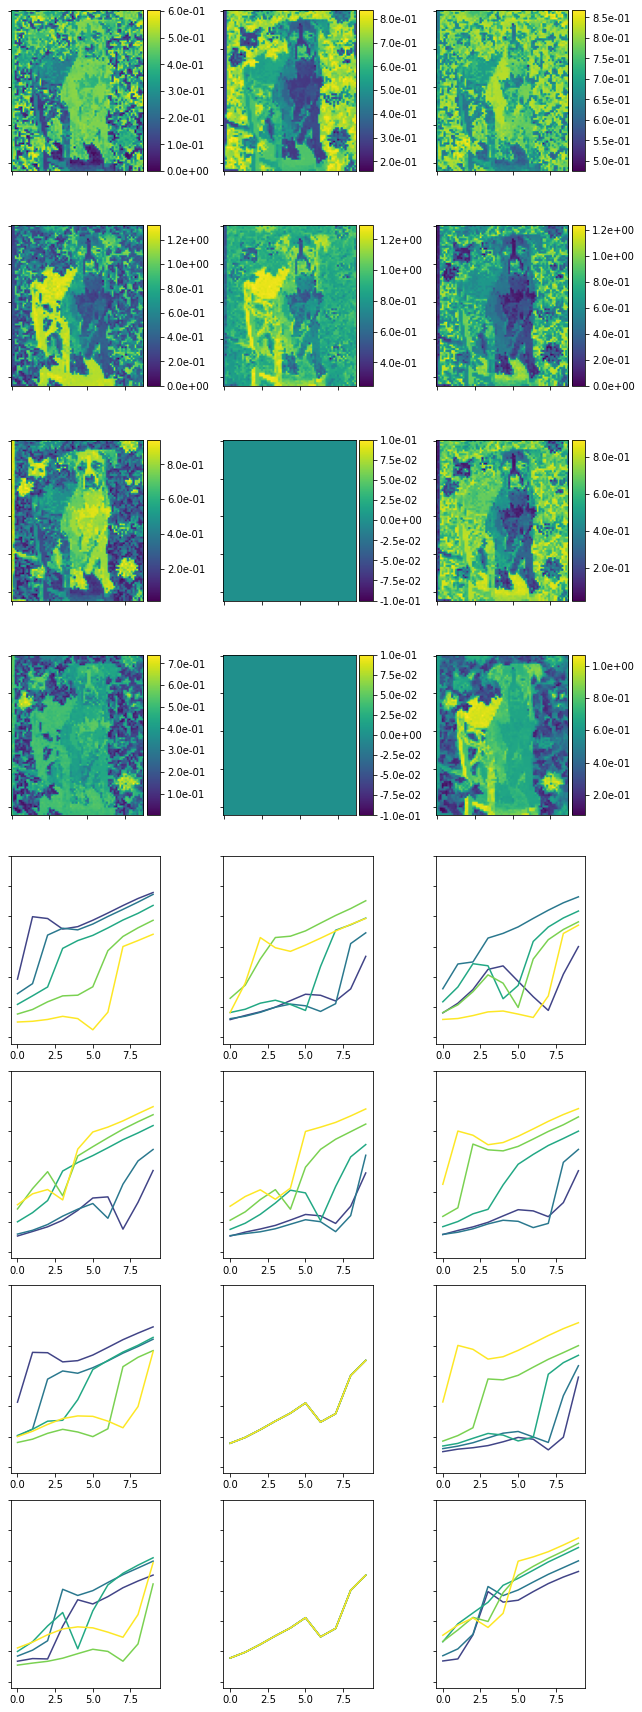

In [245]:
generate_data(decoder, encoded_spectra, image, 5, 10)

#L1

# Beta VAE

In [52]:
latent_dim = 12 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(10, activation='linear'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.build(X_train.shape)

NameError: ignored

In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (4760, 12)                132       
_________________________________________________________________
sequential_1 (Sequential)    (4760, 10)                130       
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=20,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/20
149/149 [==============================] - 0s 3ms/step - loss: 1.5741 - val_loss: 0.3301
Epoch 2/20
149/149 [==============================] - 0s 2ms/step - loss: 0.2107 - val_loss: 0.1445
Epoch 3/20
149/149 [==============================] - 0s 2ms/step - loss: 0.1228 - val_loss: 0.1040
Epoch 4/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0932 - val_loss: 0.0831
Epoch 5/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0683
Epoch 6/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0559
Epoch 7/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0457
Epoch 8/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0372
Epoch 9/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0308
Epoch 10/20
149/149 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0259

In [ ]:
encoded_spectra = autoencoder.encoder(dog_data).numpy()
decoded_spectra = autoencoder.decoder(encoded_spectra).numpy()

In [ ]:
maps = encoded_spectra.reshape(image.shape[0], image.shape[1],-1)

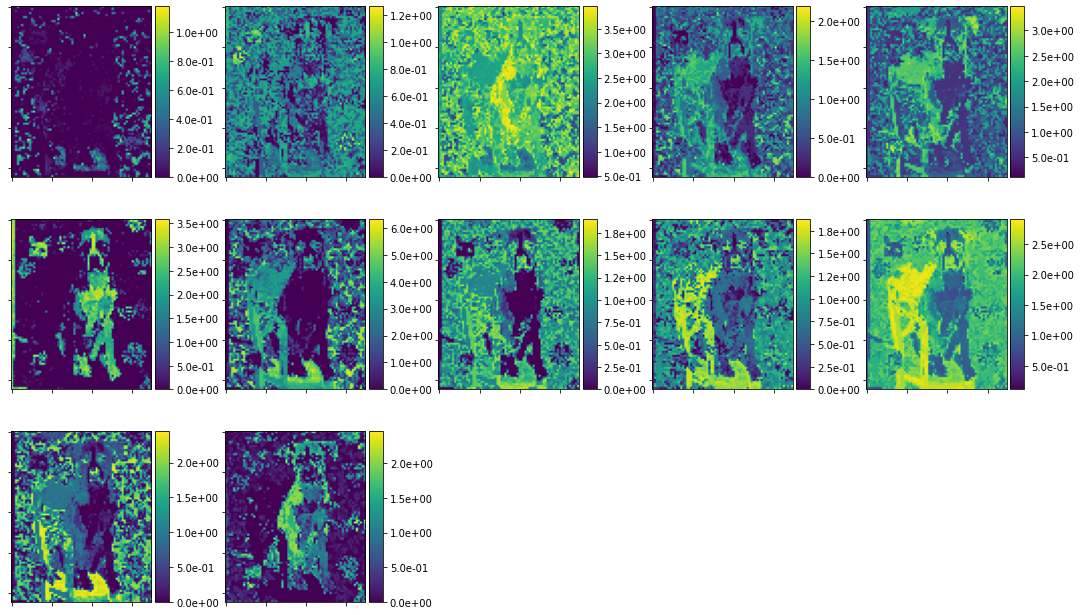

In [ ]:
embedding_maps(encoded_spectra, image)

In [ ]:
tf.random.set_seed(42)

autoencoder = Autoencoder(3)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.build(X_train.shape)

In [ ]:
tf.random.set_seed(42)

autoencoder.fit(X_train, X_train,
                epochs=50,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
149/149 [==============================] - 0s 3ms/step - loss: 0.8591 - val_loss: 0.5388
Epoch 2/50
149/149 [==============================] - 0s 2ms/step - loss: 0.4494 - val_loss: 0.3701
Epoch 3/50
149/149 [==============================] - 0s 2ms/step - loss: 0.3242 - val_loss: 0.2749
Epoch 4/50
149/149 [==============================] - 0s 2ms/step - loss: 0.2433 - val_loss: 0.2102
Epoch 5/50
149/149 [==============================] - 0s 2ms/step - loss: 0.1906 - val_loss: 0.1704
Epoch 6/50
149/149 [==============================] - 0s 2ms/step - loss: 0.1602 - val_loss: 0.1491
Epoch 7/50
149/149 [==============================] - 0s 2ms/step - loss: 0.1440 - val_loss: 0.1376
Epoch 8/50
149/149 [==============================] - 0s 2ms/step - loss: 0.1352 - val_loss: 0.1313
Epoch 9/50
149/149 [==============================] - 0s 2ms/step - loss: 0.1301 - val_loss: 0.1273
Epoch 10/50
149/149 [==============================] - 0s 2ms/step - loss: 0.1267 - val_loss: 0.1246

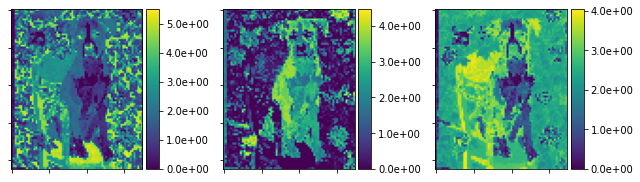

In [ ]:
encoded_spectra = autoencoder.encoder(dog_data).numpy()
decoded_spectra = autoencoder.decoder(encoded_spectra).numpy()
embedding_maps(encoded_spectra, image)

# Considering the Temporal Information
* Dense layers do not consider time
* If the order of the samples were mixed the model would appear the same
